In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv', parse_dates = True, index_col = 'DATE')

In [3]:
df.columns = ['Sales']


In [4]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


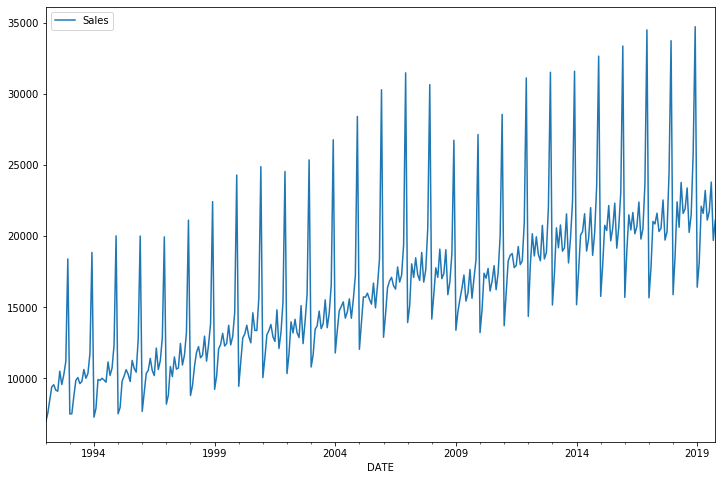

In [5]:
df.plot(figsize = (12, 8))

In [9]:
len(df)

334

In [6]:
len(df)-18

316

In [7]:
test_index = len(df)-18

In [8]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scalar = MinMaxScaler()

In [11]:
scalar.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
scalar_train = scalar.transform(train)

In [13]:
scalar_test = scalar.transform(test) 

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 12
generator = TimeseriesGenerator(scalar_train,scalar_train,length= length, batch_size=1)

In [17]:
X,y = generator[0]

In [18]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [22]:
y

array([[0.02047633]])

In [19]:
from tensorflow.keras.models import Sequential

In [20]:
from tensorflow.keras.layers import Dense, LSTM

In [21]:
n_feature = 1

In [22]:
model =Sequential()
model.add(LSTM(100, activation ='relu', input_shape = (length,n_feature)))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss= 'mse')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [26]:
validation_generator = TimeseriesGenerator(scalar_test, scalar_test, length=length, batch_size = 1)

In [27]:
model.fit_generator(generator, epochs =20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
304/304 [==============================] - 22s 71ms/step - loss: 0.0256 - val_loss: 0.0036
Epoch 2/20
304/304 [==============================] - 14s 45ms/step - loss: 0.0164 - val_loss: 0.0024
Epoch 3/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0138 - val_loss: 0.0086
Epoch 4/20
304/304 [==============================] - 14s 46ms/step - loss: 0.0044 - val_loss: 0.0048


In [28]:
losses = pd.DataFrame(model.history.history) 

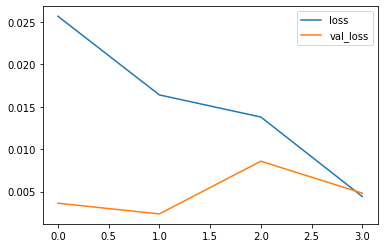

In [29]:
losses.plot()

In [30]:
test_predication = []
first_eval_batch = scalar_train[-length:]
current_batch = first_eval_batch.reshape(1, length, n_feature)

    

In [31]:
current_batch

array([[[0.53252977],
        [0.48591345],
        [0.49364653],
        [0.56629393],
        [0.46405751],
        [0.48536886],
        [0.63534708],
        [0.97233517],
        [0.32468051],
        [0.42285071],
        [0.5615016 ],
        [0.49658728]]])

In [32]:
first_eval_batch

array([[0.53252977],
       [0.48591345],
       [0.49364653],
       [0.56629393],
       [0.46405751],
       [0.48536886],
       [0.63534708],
       [0.97233517],
       [0.32468051],
       [0.42285071],
       [0.5615016 ],
       [0.49658728]])

In [33]:
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predication.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis =1)

In [37]:
test_predication

[array([0.45182997], dtype=float32),
 array([0.42517108], dtype=float32),
 array([0.4289114], dtype=float32),
 array([0.46878615], dtype=float32),
 array([0.4116703], dtype=float32),
 array([0.4240615], dtype=float32),
 array([0.5323786], dtype=float32),
 array([0.8239146], dtype=float32),
 array([0.32821298], dtype=float32),
 array([0.3755545], dtype=float32),
 array([0.44956195], dtype=float32),
 array([0.4097196], dtype=float32),
 array([0.38499725], dtype=float32),
 array([0.3706634], dtype=float32),
 array([0.37202102], dtype=float32),
 array([0.39115262], dtype=float32),
 array([0.3619439], dtype=float32),
 array([0.36820257], dtype=float32)]

In [34]:
true_predication = scalar.inverse_transform(test_predication)

In [35]:
test['Predication'] = true_predication

/Users/Prajeesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
test

,Sales,Predication
DATE,,
2018-05-01,23764,19646.866511
2018-06-01,21589,18851.173331
2018-07-01,21919,19105.271134
2018-08-01,23381,20613.854175
2018-09-01,20260,18599.266443
2018-10-01,21473,19137.588990
2018-11-01,25831,22448.122722
2018-12-01,34706,31018.747368
2019-01-01,16410,15312.179368


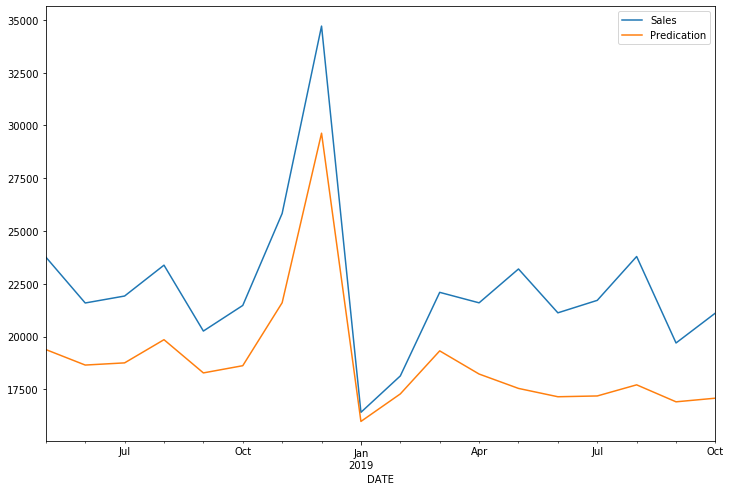

In [36]:
test.plot(figsize =(12,8))

In [45]:
full_scalar = MinMaxScaler()
scalled_full_data = full_scalar.fit_transform(df)

In [46]:
length = 12 

In [47]:
generator = TimeseriesGenerator(scalled_full_data,scalled_full_data, length=length, batch_size=1)

In [48]:
model =Sequential()
model.add(LSTM(100, activation ='relu', input_shape = (length,n_feature)))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss= 'mse')

model.fit_generator(generator, epochs=4)

Epoch 1/4
322/322 [==============================] - 15s 47ms/step - loss: 0.0273
Epoch 2/4
322/322 [==============================] - 12s 39ms/step - loss: 0.0189
Epoch 3/4
322/322 [==============================] - 14s 44ms/step - loss: 0.0153
Epoch 4/4
322/322 [==============================] - 13s 40ms/step - loss: 0.0057


In [54]:
forcast = []
period = 12
first_eval_batch = scalled_full_data[-length:]
current_batch = first_eval_batch.reshape(1, length, n_feature)
for i in range(period):
    current_pred = model.predict(current_batch)[0]
    forcast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis =1)

In [55]:
forcast

[array([0.7303926], dtype=float32),
 array([1.114701], dtype=float32),
 array([0.4009111], dtype=float32),
 array([0.4599284], dtype=float32),
 array([0.57045764], dtype=float32),
 array([0.5633083], dtype=float32),
 array([0.6143331], dtype=float32),
 array([0.5560161], dtype=float32),
 array([0.57907873], dtype=float32),
 array([0.64613044], dtype=float32),
 array([0.5277092], dtype=float32),
 array([0.58785444], dtype=float32)]

In [58]:
forcast = scalar.inverse_transform(forcast)

In [59]:
forcast

array([[27055.93309307],
       [37641.325243  ],
       [17980.69513893],
       [19606.26766682],
       [22650.68516207],
       [22453.7637763 ],
       [23859.19071817],
       [22252.90711498],
       [22888.14464712],
       [24735.01691151],
       [21473.22182131],
       [23129.86283255]])

In [60]:
forcast_index = pd.date_range(start = '2019-11-01', periods= period, freq="MS")

In [61]:
forcast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [62]:
forcast_df = pd.DataFrame(data=forcast,index= forcast_index, columns=['Forcast'])

In [63]:
forcast_df

,Forcast
2019-11-01,27055.933093
2019-12-01,37641.325243
2020-01-01,17980.695139
2020-02-01,19606.267667
2020-03-01,22650.685162
2020-04-01,22453.763776
2020-05-01,23859.190718
2020-06-01,22252.907115
2020-07-01,22888.144647
2020-08-01,24735.016912


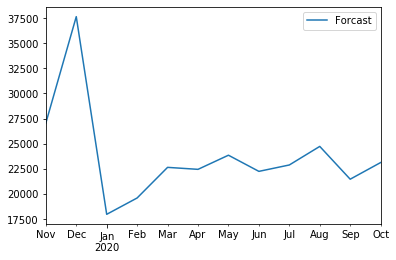

In [64]:
forcast_df.plot()

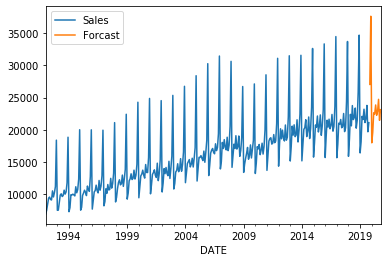

In [67]:
ax= df.plot()
forcast_df.plot(ax=ax)

(576, 611)

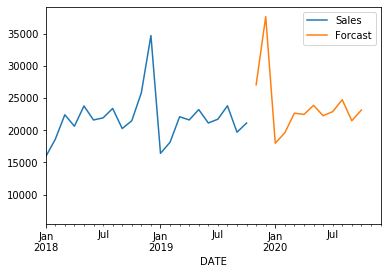

In [69]:
ax= df.plot()
forcast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01')